In [1]:
# Calculating the field in a levitator using the matrix method discussed in 
# Andrade et al. ''Matrix method for acoustic levitation simulation''
# May help for optimizing parameters in our levitator,
#  especially curvature radius of the reflector 

## _v2: calculate using lists of points instead of meshgrids for more flexible geometries
## _v3: Instead of a 3D array of field points, calculate & plot xz and xy slices at mid-planes. 
import numpy as np
import pylab as plt
import numpy.ma as ma
from mpl_toolkits import mplot3d
from time import time
import sys

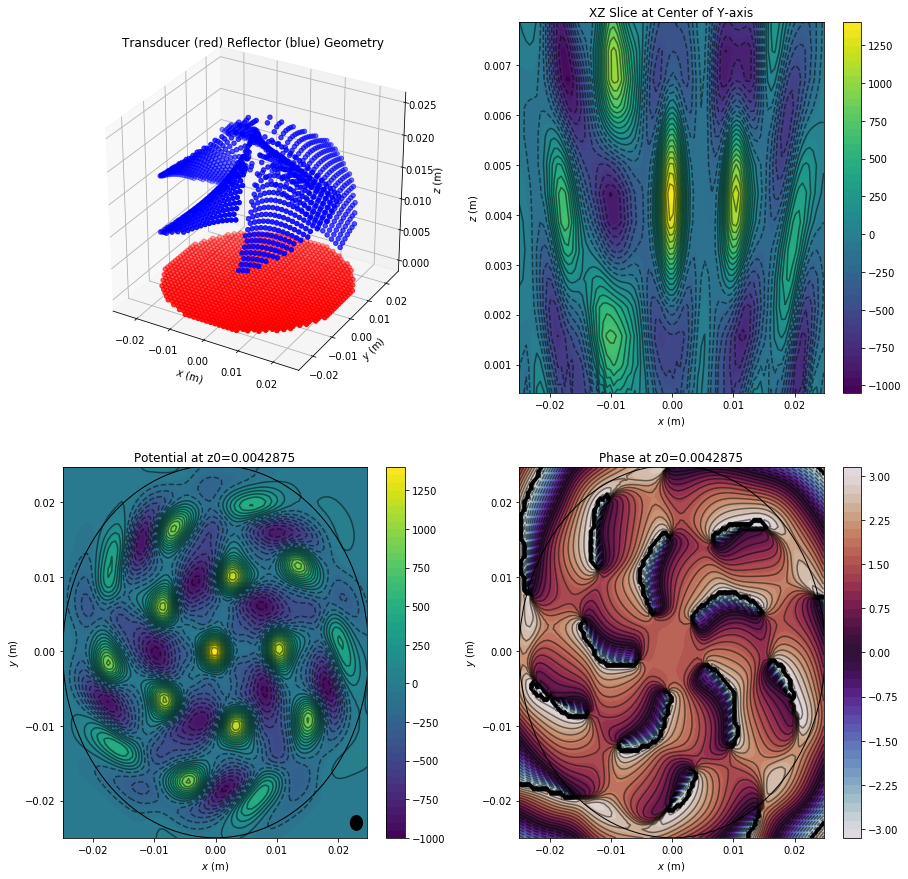

In [50]:
# Constants
freq = 40000
omega = 2*np.pi*freq
c = 343
wavel = c/freq
k = 2 * np.pi/wavel
rho = 1 
a = 10**(-3)

# Initialize the list of points representing the transducer
def grid_circle(R,d,x0,y0,z0):
    x_points = np.arange(-R,R,d)+x0
    y_points = np.arange(-R,R,d)+y0
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    indx = np.where((positions[0,:]-x0)**2+(positions[1,:]-y0)**2<R**2)[0]
    positions = positions[:,indx]
    return positions

# Planar reflector
def grid_rectangle(Rx,Ry,d,z0):
    x_points = np.arange(-Rx,Rx,d)
    y_points = np.arange(-Ry,Ry,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    return positions

# Planar reflector w/ phase ramp
def rectangle_phaseramp(Rx,Ry,d,z0,m,delta,phs):
    x_points = np.arange(-Rx,Rx,d)
    y_points = np.arange(-Ry,Ry,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    phi = np.arctan2(positions[1,:],positions[0,:])
    positions[2,:] -= delta*np.cos(m*phi+phs)
    return positions

# Planar reflector with tilt
def grid_tilt(Rx,Ry,d,z0,theta):
    x_points = np.arange(-Rx,Rx,d)
    y_points = np.arange(-Ry,Ry,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    positions[2,:]+= positions[0,:]*np.tan(theta)
    return positions

# Spherical cap reflector
def grid_spherical(R,d,z0,Rc):
    #R: extent of reflector 
    #Rc: Curvature radius of sphere
    x_points = np.arange(-R,R,d)
    y_points = np.arange(-R,R,d)
    z_points = 0
    zc = z0 - np.sqrt(Rc**2-R**2) # center of sphere
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    positions[2,:]+= np.sqrt(Rc**2-positions[0,:]**2-positions[1,:]**2)+zc
    r = np.sqrt(positions[0,:]**2 + positions[1,:]**2)
    indx = np.where(r<R)[0]
    positions = positions[:,indx]
    return positions

# Planar reflector with small hole
def grid_planar_hole(R,d,z0,Rh):
    x_points = np.arange(-R,R,d)
    y_points = np.arange(-R,R,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    indx = np.where(positions[0,:]**2+positions[1,:]**2>Rh**2)[0]
    positions = positions[:,indx]
    return positions

# Conical reflector
def grid_conical(R,d,z0,alpha):
    x_points = np.arange(-R,R,d)
    y_points = np.arange(-R,R,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    r = np.sqrt(positions[0,:]**2 + positions[1,:]**2)
    positions[2,:] += (R-r)/np.tan(alpha)
    indx = np.where(r<R)[0]
    positions = positions[:,indx]
    return positions

# Conical reflector with azimuthal phase ramp
def conical_phaseramp(R,d,z0,alpha,m):
    x_points = np.arange(-R,R,d)
    y_points = np.arange(-R,R,d)
    z_points = z0
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    r = np.sqrt(positions[0,:]**2 + positions[1,:]**2)
    positions[2,:] += (R-r)/np.tan(alpha)
    indx = np.where(r<R)[0]
    positions = positions[:,indx]
    phi = np.arctan2(positions[1,:],positions[0,:])
    positions[2,:] += np.mod(m*phi,2*np.pi)/k
    return positions

# Invert so cone vertex points toward transducer
def conical_phaseramp_inv(R,d,z0,alpha,m):
    x_points = np.arange(-R,R,d)
    y_points = np.arange(-R,R,d)
    z_points = z0+R/np.tan(alpha)
    g= np.meshgrid(x_points,y_points,z_points)
    positions = np.vstack(list(map(np.ravel,g)))
    r = np.sqrt(positions[0,:]**2 + positions[1,:]**2)
    positions[2,:] -= (R-r)/np.tan(alpha)
    indx = np.where(r<R)[0]
    positions = positions[:,indx]
    phi = np.arctan2(positions[1,:],positions[0,:])
    positions[2,:] += np.mod(m*phi,2*np.pi)/k
    return positions

## Try to get a grid of point traps with some intuitive guesses:



# # Target points (internal volume)
# def field_points_old(Rx,Ry,Rz,d,x0,y0,z0):
#     x_points = np.arange(-Rx,Rx,d) + x0
#     y_points = np.arange(-Ry,Ry,d) + y0
#     z_points = np.arange(-Rz,Rz,d) + z0
#     g= np.meshgrid(x_points,y_points,z_points)
#     print(np.shape(g))
#     positions = np.vstack(list(map(np.ravel,g)))
#     return positions, g

# Function options for mid-plane xy and xz slices
def field_points(Rx,Ry,Rz,d,x0,y0,z0, plane=None):
    if plane == None:
        x_points = np.arange(-Rx,Rx,d) + x0
        y_points = np.arange(-Ry,Ry,d) + y0
        z_points = np.arange(-Rz,Rz,d) + z0
        g= np.meshgrid(x_points,y_points,z_points)
        positions = np.vstack(list(map(np.ravel,g)))
    if plane == 'xy':
        x_points = np.arange(-Rx,Rx,d) + x0
        y_points = np.arange(-Ry,Ry,d) + y0
        z_points = np.asarray([-d,0,d]) + z0
        g= np.meshgrid(x_points,y_points,z_points)
        positions = np.vstack(list(map(np.ravel,g)))
    if plane == 'xz':
        x_points = np.arange(-Rx,Rx,d) + x0
        y_points = np.asarray([-d,0,d]) + y0
        z_points = np.arange(-Rz,Rz,d) + z0
        g= np.meshgrid(x_points,y_points,z_points)
        positions = np.vstack(list(map(np.ravel,g)))
    return positions, g

def transfer(source,target):
    t = time()
    dx = target[0,:,None] - source[0,None,:]
    dy = target[1,:,None] - source[1,None,:]
    dz = target[2,:,None] - source[2,None,:]
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    source_area = d_t**2 # area represented per gridpoint, currently only accurate for constant z surfaces
#     print('Transfer matrix calculated in: {} s'.format(time()-t))
    return source_area * (np.exp(-1j*k*r))/r

def transducer_output(points, amplitude, phase):
    output = np.ones(np.shape(points[0,:]),dtype='complex') * amplitude * np.exp(1j*phase)
    return output

# Serves as a dictionary for the terms in the expansion
def calculate_term(num):
    opt = 'optimal'
    t = time()
    pref = 1j/wavel
    if num ==1:
        term = np.einsum('mt,t',TTM, U , optimize=opt)
    if num ==2:
        term = pref * np.einsum('mr,rt,t',TRM,TTR,U, optimize=opt)
    if num ==3:
        term = pref**2 * np.einsum('mt,tr,rt,t' ,TTM,TRT,TTR,U, optimize=opt)
    if num ==4:
        term = pref**3 * np.einsum('mr,rt,tr,rt,t',TRM,TTR,TRT,TTR,U, optimize=opt)
    if num ==5: 
        term = pref**4 * np.einsum('mt,tr,rt,tr,rt,t',TTM,TRT,TTR,TRT,TTR,U, optimize=opt)
#     print('Term {}: {} s'.format(num,time()-t))
    return term


# Calculate potential field at level of accuracy given by num_terms
def calculate_fields(num_terms):
    pref1 = omega*rho*c/wavel
    terms = []
    for i in range(num_terms):
        terms.append(calculate_term(i+1)) #count terms starting at 1 rather than 0
    terms = np.vstack(terms) 
    pressure = pref1*np.sum(terms,axis=0)
    
    
    if plane == 'xz':
        pressure_grid = np.reshape(pressure, np.shape(field_grid_xz[0]))
    if plane == 'xy':
        pressure_grid = np.reshape(pressure, np.shape(field_grid_xy[2]))
    if plane == None:
        pressure_grid = np.reshape(pressure, np.shape(field_grid[0]))
    velocity = np.gradient(-pressure_grid/(1j*omega*rho), d_f)
    pressure_squared = pressure*np.conjugate(pressure)
    
    phase_grid = np.angle(pressure_grid)
    
    velocity_squared = np.einsum('aijk,aijk->ijk',velocity,np.conjugate(velocity))
    velocity_squared = np.ravel(velocity_squared)
    potential = np.real( 2*np.pi*a**3 *(pressure_squared/(3*rho*c**2) - rho*velocity_squared/2) )
    
    if plane =='xz':
        potential_grid = np.reshape(potential,np.shape(field_grid_xz[0]))
    if plane =='xy':
        potential_grid = np.reshape(potential,np.shape(field_grid_xy[2]))
    if plane == None:
        potential_grid = np.reshape(potential, np.shape(field_grid[0]))
    force_grid = np.gradient(-potential_grid, d_f)
    return potential_grid, phase_grid

## Inputs 
R_t = 2.5*10**(-2)# our transducer is 2.5 cm radius
R_r = R_t
R_f = R_t
d_t = R_t/20 # grid spacing for (t)ransducer, (r)eflector, (f)ield
d_r = R_r/20
d_f = wavel/15

H = (2/2)*wavel # z position of reflector

x0_t, y0_t, z0_t = [0,0,0] # transducer center

transducer = grid_circle(R_t,d_t,x0_t,y0_t,z0_t)
#reflector = grid_rectangle(R_r,R_r,d_r,H)
# reflector = grid_tilt(R_r,R_r,d_r,H,(10/180)*np.pi)
#reflector = grid_spherical(R_t*2,d_r,H,.06)
#reflector = grid_planar_hole(R_r,d_r,H,wavel/2)
#reflector = grid_conical(R_r,d_r,H,(70/180)*np.pi)
reflector = conical_phaseramp(R_r,d_r,H,(70/180)*np.pi,5)
#reflector = rectangle_phaseramp(R_r,R_r,d_r,H,1,R_r*.02,0)

# start sampling just above transducer to avoid diverging pressure at transducer face

U = transducer_output(transducer, 1, 0)
TTR = transfer(transducer,reflector) # Transducer to Reflector
TRT = transfer(reflector,transducer) # Reflector to Transducer
z0 = wavel/2 # z-pos of xy plane images

for plane in ['xy','xz']:
    if plane == 'xy':
        field_xy, field_grid_xy = field_points(R_f, R_f ,H/2*.9,d_f,0,0,z0 , plane=plane) 
        TTM = transfer(transducer,field_xy) # Transfer Transducer (to) Measurement points (field)
        TRM = transfer(reflector,field_xy) # Reflector to Measurement points
        potential_grid_xy, phase_grid_xy = calculate_fields(5)
    if plane == 'xz':
        field_xz, field_grid_xz = field_points(R_f, R_f ,H/2*.9,d_f,0,0,H/2 , plane=plane) 
        TTM = transfer(transducer,field_xz) # Transfer Transducer (to) Measurement points (field)
        TRM = transfer(reflector,field_xz) # Reflector to Measurement points
        potential_grid_xz, phase_grid_xz = calculate_fields(5)


## Plotting
midX = int(np.ceil(2*R_f/d_f)/2)
midY = int(np.ceil(2*R_f/d_f)/2)
midZ = int(np.ceil(H*.9/d_f)/2)

time_tag = str(int(time()))
imgformat = '.png'
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(15,15))

# Plot 1: 3D image of transducer/reflector geometry
ax[0,0].remove()
ax3d = fig.add_subplot(2,2,1, projection='3d')
ax3d.scatter(transducer[0,:], transducer[1,:],transducer[2,:],color='r')
ax3d.scatter(reflector[0,:], reflector[1,:],reflector[2,:],color='blue')
ax3d.set_title('Transducer (red) Reflector (blue) Geometry')
ax3d.set_xlabel(r'$x$ (m)')
ax3d.set_ylabel(r'$y$ (m)')
ax3d.set_zlabel(r'$z$ (m)')
# Plot 2: xz slice at midplane
ax[0,1].set_title('XZ Slice at Center of Y-axis')
cpl = ax[0,1].contourf(field_grid_xz[0][0,:,0],field_grid_xz[2][0,0,:],potential_grid_xz[1,:,:].transpose(),levels=50)
fig.colorbar(cpl,ax=ax[0,1])
ax[0,1].contour(field_grid_xz[0][0,:,0],field_grid_xz[2][0,0,:],potential_grid_xz[1,:,:].transpose(),levels=25, zorder=3,colors='black',alpha=0.5)
ax[0,1].set_xlabel(r'$x$ (m)')
ax[0,1].set_ylabel(r'$z$ (m)')

# Plot 3: xy slice at midplane
ax[1,0].set_title('Potential at z0={}'.format(z0))
cpl = ax[1,0].contourf(field_grid_xy[0][0,:,0],field_grid_xy[1][:,0,0],potential_grid_xy[:,:,1],levels=50)
fig.colorbar(cpl,ax=ax[1,0])
ax[1,0].contour(field_grid_xy[0][0,:,0],field_grid_xy[1][:,0,0],potential_grid_xy[:,:,1],levels=25, zorder=3,colors='black',alpha=0.5)
ax[1,0].set_xlabel(r'$x$ (m)')
ax[1,0].set_ylabel(r'$y$ (m)')
circle1 = plt.Circle((0,0), R_t, fill = False)
a_p = 10**-3 # particles ~ 1mm radius
particle = plt.Circle((R_t-2*a_p,-(R_t-2*a_p)),a_p, color='black')
ax[1,0].add_artist(circle1)
ax[1,0].add_artist(particle)
# Plot 4: Show phase in xy slice

ax[1,1].set_title('Phase at z0={}'.format(z0))
cpl = ax[1,1].contourf(field_grid_xy[0][0,:,0],field_grid_xy[1][:,0,0],phase_grid_xy[:,:,1],levels=50,cmap='twilight')
fig.colorbar(cpl,ax=ax[1,1])
ax[1,1].contour(field_grid_xy[0][0,:,0],field_grid_xy[1][:,0,0],phase_grid_xy[:,:,1],levels=25, zorder=3,colors='black',alpha=0.5)
ax[1,1].set_xlabel(r'$x$ (m)')
ax[1,1].set_ylabel(r'$y$ (m)')
circle2 = plt.Circle((0,0), R_t, fill = False)
ax[1,1].add_artist(circle2)

plt.show()
# save = input("Save figure? (enter file name if yes, return if no)")
# if save != '':
#     fileName = 'images/{}{}'.format(save,imgformat)
#     fig.savefig(fileName)
#     print("Figure saved to {}".format(fileName))

01

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in sqrt


049

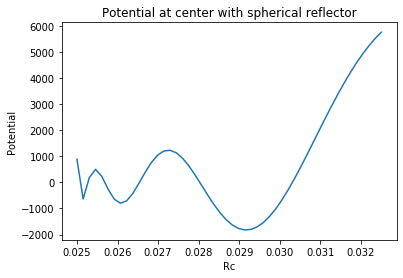

In [3]:
## For fixed geometry, tune parameters and plot potential at a specific point
## Inputs 
d_t = wavel/5 # grid spacing for (t)ransducer, (r)eflector, (f)ield
d_r = wavel/5
d_f = wavel/10
R_t = 2.5*10**(-2)# our transducer is 2.5 cm radius
R_r = R_t
R_f = R_t
H = wavel*(3/2) # z position of reflector

x0_t, y0_t, z0_t = [0,0,0] # transducer center

R_vals = [R_t]
Rc_vals = np.linspace(R_vals[0]*1,R_vals[0]*1.3, 50)
potentials = np.zeros((len(R_vals) , len(Rc_vals)))
plane = None

transducer = grid_circle(R_t,d_t,x0_t,y0_t,z0_t)
U = transducer_output(transducer, 1, 0)   
field, field_grid = field_points(d_f,d_f,d_f,d_f, 0,0,H/2, plane=plane)
TTM = transfer(transducer,field)
for i, R in enumerate(R_vals):
    for j, Rc in enumerate(Rc_vals):

        reflector = grid_spherical(R,d_r,H, Rc)

        TTR = transfer(transducer,reflector) # Transducer to Reflector
        TRT = transfer(reflector,transducer) # Reflector to Transducer
        TRM = transfer(reflector, field)
        potential_grid,_ = calculate_fields(5)
        
        sys.stdout.write("\r"+str(i)+str(j))
        sys.stdout.flush()
        potentials[i,j] = potential_grid[1,1,1]
        

fig, ax = plt.subplots()

if any(list(np.shape(potentials)))!=1:
    cpl = ax.contourf(R_vals,Rc_vals,potentials.transpose())
    fig.colorbar(cpl, ax=ax)
    ax.set_xlabel('R')
    ax.set_ylabel('Rc')
    ax.set_title('Potential at center with spherical reflector')
if any(list(np.shape(potentials)))==1:
    ax.plot(Rc_vals, potentials[0])
    ax.set_xlabel('Rc')
    ax.set_ylabel('Potential')
    ax.set_title('Potential at center with spherical reflector')

Optimal Height: 0.01190972222222222 mm; 1.3888888888888888 wavelengths


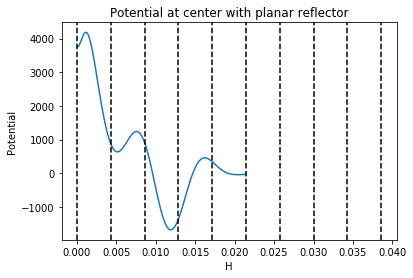

In [11]:
## For plane reflector, tune spacing 
## Inputs 
d_t = wavel/5 # grid spacing for (t)ransducer, (r)eflector, (f)ield
d_r = wavel/5
d_f = wavel/10
R_t = 2.5*10**(-2)# our transducer is 2.5 cm radius
R_r = 5*10**(-2) # our reflector is a square, 10cm sides
R_f = R_t
H = wavel*(3/2) # z position of reflector

x0_t, y0_t, z0_t = [0,0,0] # transducer center


H_vals = np.linspace(0,(5/2)*wavel, 100)
potentials = np.zeros(len(H_vals))
plane = None

transducer = grid_circle(R_t,d_t,x0_t,y0_t,z0_t)
U = transducer_output(transducer, 1, 0)   

for i, H in enumerate(H_vals):

    field, field_grid = field_points(d_f,d_f,d_f,d_f, 0,0,H/2, plane=plane)
    TTM = transfer(transducer,field)
    reflector = grid_rectangle(R_r,R_r,d_r,H)

    TTR = transfer(transducer,reflector) # Transducer to Reflector
    TRT = transfer(reflector,transducer) # Reflector to Transducer
    TRM = transfer(reflector, field)
    potential_grid,_ = calculate_fields(5)

    sys.stdout.write("\r"+str(i))
    sys.stdout.flush()
    potentials[i] = potential_grid[1,1,1]
sys.stdout.write("\r")
optimal_height = H_vals[np.argmin(potentials)]
num_wavelengths = optimal_height/wavel
print('Optimal Height: {} mm; {} wavelengths'.format(optimal_height,num_wavelengths))

fig, ax = plt.subplots()



ax.plot(H_vals, potentials)
ax.set_xlabel('H')
ax.set_ylabel('Potential')
ax.set_title('Potential at center with planar reflector')
for i in range(10):
    ax.axvline(i*wavel/2,ymin=0,ymax=1,color='k',ls='--')

In [5]:
# %load_ext line_profiler
# %lprun -f  

H/2

In [6]:
H

0.042874999999999996

In [7]:
.037/(wavel/2)

8.629737609329446